# Purpose
Transforms Modelica CSV files into separate CSV files for combining with measured data to calculate validation metrics of NMBE and CV(RMSE).

In [ ]:
# connect to goolgle drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

# 1 Setup

In [ ]:
# dir, paths
in_dir =  r'/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/NREL OpenStudio Model/4 Validation' #r'https://raw.githubusercontent.com/NREL/BEEAM/flexlab-develop/FMU/flexlab_ac_dc'
out_dir = r'/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/NREL OpenStudio Model/4 Validation'
ac_csv_path = os.path.join(in_dir, 'flexlab_ac_Cable.csv')
dc_csv_path = os.path.join(in_dir, 'flexlab_dc_2.csv')

# index column
idx_col = 'Time'

# origin for converting timestamps to datetime format
origin = pd.Timestamp('2020-01-01 00:00')
unit = 's'

# AC experiment beginning and end timestamps
ac_lo_beg = '2020-11-11 10:30'
ac_lo_end = '2020-11-11 17:00'
ac_md_beg = '2020-11-12 14:30'
ac_md_end = '2020-11-13 11:30'
ac_hi_beg = '2020-11-13 12:00'
ac_hi_end = '2020-11-16 08:00'
ac_beg = ac_lo_beg
ac_end = ac_hi_end

# DC experiment beginning and end timestamps
dc_hi_beg = '2020-11-17 18:00'
dc_hi_end = '2020-11-20 16:00'
dc_lo_beg = '2020-11-23 11:30'
dc_lo_end = '2020-11-25 08:45'
dc_md_beg = '2020-11-25 09:30'
dc_md_end = '2020-11-30 08:00'
dc_beg = dc_hi_beg
dc_end = dc_md_end

# column names for separate files
clg_col = 'PTAC_Clg_Coil_Cooling_Rate'
fan_col = 'PTAC_Fan_electric_rate'
plnm_temp_col = 'PlnmB_zone_temp'
zone_temp_col = 'ZoneB_zone_temp'
pwr_col = 'Vin.P'

# 2 Extract

In [ ]:
# read csvs to dataframes
ac_df = pd.read_csv(ac_csv_path)
dc_df = pd.read_csv(dc_csv_path)

# show
ac_df, dc_df

(            Time  systemDef.hrms[1]  ...   CPUtime  EventCounter
 0     27216000.0                  1  ...  5.184999             3
 1     27216900.0                  1  ...  5.188391             3
 2     27216900.0                  1  ...  5.205755             6
 3     27217800.0                  1  ...  5.206602             6
 4     27217800.0                  1  ...  5.211056             9
 ...          ...                ...  ...       ...           ...
 1148  27732600.0                  1  ...  7.561513          1725
 1149  27733500.0                  1  ...  7.562079          1725
 1150  27733500.0                  1  ...  7.564965          1728
 1151  27734400.0                  1  ...  7.565535          1728
 1152  27734400.0                  1  ...  7.570095          1731
 
 [1153 rows x 3643 columns],
             Time  systemDef.hrms[1]  ...   CPUtime  EventCounter
 0     27648000.0                  1  ...  4.907096             3
 1     27648900.0                  1  ...  4.

# 3 Transform

## 3.1 Timestamps

In [ ]:
# loop through dataframes
for df in [ac_df, dc_df]: 
    
    # change time column to datetime format based on units and origin
    df[idx_col] = pd.to_datetime(df[idx_col], unit=unit, origin=origin)

    # add row of zeros at index -1 to end of dataframe to make rows even prior to removing duplicates
    df.loc[-1] = 0

    # shift index back to zero-based (not really needed)
    df.index = df.index + 1

    # sort index so that new row is first
    df.sort_index(inplace=True)

    # set time column of new first row to same value as second row
    df.loc[0, idx_col] = df.loc[1, idx_col]

    # drop duplicates
    df.drop_duplicates(subset=[idx_col], keep='last', inplace=True)

    # rename timestamp column
    df.rename(columns={idx_col:'datetime'}, inplace=True)

    # set index to time column
    df.set_index('datetime', inplace=True)

# show
ac_df, dc_df

(                     systemDef.hrms[1]  ...  EventCounter
 datetime                                ...              
 2020-11-11 00:00:00                  1  ...             3
 2020-11-11 00:15:00                  1  ...             6
 2020-11-11 00:30:00                  1  ...             9
 2020-11-11 00:45:00                  1  ...            12
 2020-11-11 01:00:00                  1  ...            15
 ...                                ...  ...           ...
 2020-11-16 23:00:00                  1  ...          1719
 2020-11-16 23:15:00                  1  ...          1722
 2020-11-16 23:30:00                  1  ...          1725
 2020-11-16 23:45:00                  1  ...          1728
 2020-11-17 00:00:00                  1  ...          1731
 
 [577 rows x 3642 columns],
                      systemDef.hrms[1]  ...  EventCounter
 datetime                                ...              
 2020-11-16 00:00:00                  1  ...             3
 2020-11-16 00:15:00      

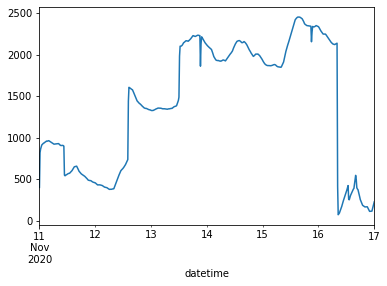

In [ ]:
ac_series = ac_df["'in_fmu1'.PTAC_Clg_Coil_Cooling_Rate"]
ac_series.plot()

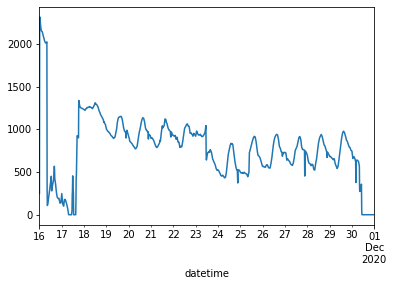

In [ ]:
dc_series = dc_df["'in_fmu1'.PTAC_Clg_Coil_Cooling_Rate"]
dc_series.plot()

## 3.2 Slice by Columns

In [ ]:
# print columns
# [print(idx, col) for idx, col in enumerate(ac_df.columns)]

# list of columns
cols_list = []
for col in dc_df.columns:
    if col == 'Vin.P' or col == 'Vin.P1' or col.startswith("'in_fmu1'") or col == 'EventCounter':
        cols_list.append(col)

cols_list

['Vin.P',
 "'in_fmu1'._PlnmBLightsDriver_start",
 "'in_fmu1'.PlnmBLightsDriver",
 "'in_fmu1'._ZoneBPlugsConverters_start",
 "'in_fmu1'.ZoneBPlugsConverters",
 "'in_fmu1'._PlnmBDCHub_start",
 "'in_fmu1'.PlnmBDCHub",
 "'in_fmu1'.PTAC_Clg_Coil_Cooling_Rate",
 "'in_fmu1'.PTAC_Fan_electric_rate",
 "'in_fmu1'.PlnmB_zone_temp",
 "'in_fmu1'.ZoneB_zone_temp",
 "'in_fmu1'.site_outdoor_air_drybulb_temperature",
 "'in_fmu1'.PlnmB_electric_heating_rate",
 "'in_fmu1'.ZoneB_electric_heating_rate",
 "'in_fmu1'.PlnmB_lights_heating_rate",
 "'in_fmu1'.ZoneB_lights_heating_rate",
 "'in_fmu1'.PlnmB_cooling_setpoint",
 "'in_fmu1'.ZoneB_cooling_setpoint",
 "'in_fmu1'.cPlnmB_heating_setpoint",
 "'in_fmu1'.ZoneB_heating_setpoint",
 "'in_fmu1'.ZoneB_plugs_heating_rate",
 "'in_fmu1'.ZoneB_light_heating_rate",
 "'in_fmu1'.fmi_loggingOn",
 "'in_fmu1'.fmi_InputTime",
 "'in_fmu1'.fmi_UsePreOnInputSignals",
 "'in_fmu1'.fmi_StartTime",
 "'in_fmu1'.fmi_StopTime",
 "'in_fmu1'.fmi_NumberOfSteps",
 "'in_fmu1'.fmi_Communi

In [ ]:
# slice by columns (didn't work by looping)
ac_df = ac_df.loc[:, cols_list]
dc_df = dc_df.loc[:, cols_list]

# show
ac_df, dc_df

(                         Vin.P  ...  EventCounter
 datetime                        ...              
 2020-11-11 00:00:00 -573.85675  ...             3
 2020-11-11 00:15:00 -909.80334  ...             6
 2020-11-11 00:30:00 -909.94086  ...             9
 2020-11-11 00:45:00 -910.04400  ...            12
 2020-11-11 01:00:00 -909.78754  ...            15
 ...                        ...  ...           ...
 2020-11-16 23:00:00  -51.26476  ...          1719
 2020-11-16 23:15:00  -51.26476  ...          1722
 2020-11-16 23:30:00  -51.26476  ...          1725
 2020-11-16 23:45:00  -51.26476  ...          1728
 2020-11-17 00:00:00  -51.26476  ...          1731
 
 [577 rows x 33 columns],                            Vin.P  ...  EventCounter
 datetime                          ...              
 2020-11-16 00:00:00   -16.598005  ...             3
 2020-11-16 00:15:00 -1851.331200  ...             6
 2020-11-16 00:30:00 -1851.397300  ...             9
 2020-11-16 00:45:00 -1851.255500  ...       

In [ ]:
# rename columns
for df in [ac_df, dc_df]: 
    for col in df.columns:
        col_str = col.replace("'in_fmu1'.", "")
        df.rename(columns={col:col_str}, inplace=True)

ac_df, dc_df

(                         Vin.P  ...  EventCounter
 datetime                        ...              
 2020-11-11 00:00:00 -573.85675  ...             3
 2020-11-11 00:15:00 -909.80334  ...             6
 2020-11-11 00:30:00 -909.94086  ...             9
 2020-11-11 00:45:00 -910.04400  ...            12
 2020-11-11 01:00:00 -909.78754  ...            15
 ...                        ...  ...           ...
 2020-11-16 23:00:00  -51.26476  ...          1719
 2020-11-16 23:15:00  -51.26476  ...          1722
 2020-11-16 23:30:00  -51.26476  ...          1725
 2020-11-16 23:45:00  -51.26476  ...          1728
 2020-11-17 00:00:00  -51.26476  ...          1731
 
 [577 rows x 33 columns],                            Vin.P  ...  EventCounter
 datetime                          ...              
 2020-11-16 00:00:00   -16.598005  ...             3
 2020-11-16 00:15:00 -1851.331200  ...             6
 2020-11-16 00:30:00 -1851.397300  ...             9
 2020-11-16 00:45:00 -1851.255500  ...       

## 3.3 Slice by Rows

In [ ]:
# slice by rows
ac_df = ac_df[ac_beg:ac_end]
dc_df = dc_df[dc_beg:dc_end]

# show
ac_df, dc_df

(                          Vin.P  ...  EventCounter
 datetime                         ...              
 2020-11-11 10:30:00  -900.78200  ...           129
 2020-11-11 10:45:00  -571.27563  ...           132
 2020-11-11 11:00:00  -573.24400  ...           135
 2020-11-11 11:15:00  -573.78780  ...           138
 2020-11-11 11:30:00  -573.82050  ...           141
 ...                         ...  ...           ...
 2020-11-16 07:00:00 -1944.64830  ...          1527
 2020-11-16 07:15:00 -1944.54680  ...          1530
 2020-11-16 07:30:00 -1944.46960  ...          1533
 2020-11-16 07:45:00 -1944.53980  ...          1536
 2020-11-16 08:00:00 -1944.36390  ...          1539
 
 [471 rows x 33 columns],                          Vin.P  ...  EventCounter
 datetime                        ...              
 2020-11-17 18:00:00 -602.23810  ...           507
 2020-11-17 18:15:00 -803.09296  ...           510
 2020-11-17 18:30:00 -803.10410  ...           513
 2020-11-17 18:45:00 -803.13430  ...      

In [ ]:
ac_df.to_csv(os.path.join(out_dir, 'ac_fmu_data.csv'))
dc_df.to_csv(os.path.join(out_dir, 'dc_fmu_data.csv'))

## 3.4 Separate

In [ ]:
# AC series
ac_clg = ac_df[clg_col]
ac_fan = ac_df[fan_col]
ac_plnm_temp = ac_df[plnm_temp_col]
ac_zone_temp = ac_df[zone_temp_col]
ac_pwr = ac_df[pwr_col]

# DC series
dc_clg = dc_df[clg_col]
dc_fan = dc_df[fan_col]
dc_plnm_temp = dc_df[plnm_temp_col]
dc_zone_temp = dc_df[zone_temp_col]
dc_pwr = dc_df[pwr_col]

# 4 Load

In [ ]:
# AC CSV files
ac_clg.to_csv(os.path.join(out_dir, 'AC_' + clg_col + '.csv'))
ac_fan.to_csv(os.path.join(out_dir, 'AC_' + fan_col + '.csv'))
ac_plnm_temp.to_csv(os.path.join(out_dir, 'AC_' + plnm_temp_col + '.csv'))
ac_zone_temp.to_csv(os.path.join(out_dir, 'AC_' + zone_temp_col + '.csv'))
ac_pwr.to_csv(os.path.join(out_dir, 'AC_' + pwr_col + '.csv'))

# DC CSV files
dc_clg.to_csv(os.path.join(out_dir, 'DC_' + clg_col + '.csv'))
dc_fan.to_csv(os.path.join(out_dir, 'DC_' + fan_col + '.csv'))
dc_plnm_temp.to_csv(os.path.join(out_dir, 'DC_' + plnm_temp_col + '.csv'))
dc_zone_temp.to_csv(os.path.join(out_dir, 'DC_' + zone_temp_col + '.csv'))
dc_pwr.to_csv(os.path.join(out_dir, 'DC_' + pwr_col + '.csv'))